# 3. 지도학습

## Rule based Fraud Detection

In [ ]:
rb_df = df.copy()

1. 고액 및 심야 시간대 조합 rule
  - 조건: transaction_amout(가격)가 특정 threshold 초과(예를 들어 100만원 초과 시) + 정상적인 시간대가 아닌 경우(자정 ~ 새벽 6시)인 경우
  - 근거: 한국에서의 비정상 시간대(예를 들어 시차로 인해 해외에서 접속할 경우)에 threshold를 넘어서는 금액인 경우 fraud일 가능성이 있음
  - 방법: 조건문 생성

2. IP 주소 기반 단기 거래 빈도 확인(velocity check)
 - 조건: 동일한 ip_address에서 짧은 시간내에 일정 횟수 이상 거래 발생하는 경우 (예를 들어 1시간 내에 5회 이상 거래 발생)
 - 근거: 동일한 IP 주소에서 여러 번 거래 탐지.
 - 방법: 시간 경과에 따른 거래 수 추적 필요

3. VPN 사용 및 고액 거래 조합
 - 조건: vpn 사용 감지, 가격이 일정 threshold 이상
 - 근거: vpn을 통해 고액거래시 위험성 존재
 - 방법: 조건문 생성

4. 취약한 인증 방식 및 고액 거래 조합
 - 조건: 인증방식 없음(authentication_unknown = True)인 경우 특정 가격 이상
 - 근거: 보안 수준이 낮은데 특정 가격 이상이면 위험성 존재
 - 방법 조건문 생성

5. 기기 정보 및 브라우저 정보가 없는데(접근 경로가 불분명한 경우) 고액 거래 조합
 - 조건: 디바이스 ID(device_id_unknown = True) 또는 브라우저(browser_unknown = True) 정보가 없는 상태에서 특정 금액 이상 송금하는 경우
 - 근거: 출처 불분명한데 높은 송금액 보내는 경우 위험성 존재
 - 방법: 조건문 생성


6. 지역 기반 규칙
 - 조건: 사용자의 일반적인 거래 지역이 아닌 다른 region에서 거래 발생하고 고액 거래 발생
 - 근거: 사용자의 평소 활동 지역이 아닌 지역일 경우, 기기나 계정 탈취 등일 가능성
 - 방법: 과거 데이터 기반으로 평소 활동지역 파악, 조건문 생성

7. 소액 다수 거래 패턴 규칙(velocity check)
- 조건: 특정 사용자 ID에 대해 짧은 시간(예: 1시간) 내에 소액(예: 10000원 미만)거래가 특정 횟수 이상 발생
- 근거: 기기 도난된 경우 유효성 판단을 위해 소액 거래를 여러번 시도하는 경우 발생 -> detection 필요
- 방법: 조건문 생성

In [ ]:
from datetime import datetime
class FraudDetector:
    def __init__(self, df):
        self.df = rb_df
        self.high_amount_threshold = self.df['transaction_amount'].quantile(0.95)
        self.low_amount_threshold = self.df['transaction_amount'].quantile(0.25)
        self.transaction_amount = 1500000
        self.high_velocity_threshold = 5
        self.fraud_flags = ['high_amount_night_flag', 'ip_velocity_flag',
                           'vpn_high_amount_flag', 'weak_auth_high_amount_flag',
                           'unknown_device_rooting_flag',
                           'low_amount_high_velocity_flag'] #'unusual_region_flag'

    def high_amount_night_time_rule(self, transaction_amount, transaction_time, threshold):
      """
      고액 및 심야 시간대 조합 rule

      Args:
        transaction_amount: 거래 금액.
        transaction_time: 거래 시간 (datetime 객체).
        threshold: 고액으로 판단할 기준 금액 (기본값: 사용자 설정).

      Returns:
        True: 조건을 만족하는 경우 (고액 및 심야 시간대 거래).
        False: 조건을 만족하지 않는 경우.
      """
      # 심야 시간대 (자정 ~ 새벽 6시) 여부 확인
      is_night_time = 0 <= transaction_time.hour < 6

      # 고액 거래 여부 확인
      is_high_amount = transaction_amount > threshold

      # 두 조건을 모두 만족하는 경우 True 반환
      return is_night_time and is_high_amount

    def ip_velocity_check(self, transaction_velocity_ip, threshold=5):
        """
        IP 주소 기반 단기 거래 빈도 확인(velocity check)
        """
        return transaction_velocity_ip > threshold

    def vpn_high_amount_check(self, is_vpn_used, transaction_amount, high_amount_threshold):
        """
        VPN 사용 및 고액 거래 조합
        """
        return (is_vpn_used == True) & (transaction_amount > high_amount_threshold)

    def weak_auth_high_amount_check(self, authentication_unknown, transaction_amount, high_amount_threshold):
        """
        취약한 인증 방식 및 고액 거래 조합
        """
        return (authentication_unknown == True) & (transaction_amount > high_amount_threshold)

    def unknown_device_browser_check(self, device_id_unknown, browser_unknown, transaction_amount, high_amount_threshold):
        """
        기기 정보 및 브라우저 정보가 없는데(접근 경로가 불분명한 경우) 고액 거래 조합
        """
        return ((device_id_unknown == True) | (browser_unknown == True)) & (transaction_amount > high_amount_threshold)

    def unusual_region_check(self, is_high_amount_unusual_region):
        """
        지역 기반 규칙
        """
        return is_high_amount_unusual_region

    def low_amount_high_velocity_check(self, transaction_amount, transaction_velocity_ip, low_amount_threshold, high_velocity_threshold=5):
        """
        소액 다수 거래 패턴 규칙(velocity check)
        """
        return (transaction_amount < low_amount_threshold) & (transaction_velocity_ip > high_velocity_threshold)

    def detect_fraud(self):
        # self.df['is_high_amount_unusual_region'] = (df['is_unusual_region']) & (df['transaction_amount'] > self.high_amount_threshold)
        self.df['transaction_velocity_ip'] = self.df.groupby('ip_address')['ip_address'].transform('count')
        self.df['is_vpn_used'] = self.df.groupby('ip_address')['vpn_1.0'].transform('max')
        self.df['high_amount_night_flag'] = self.df.apply(lambda row: self.high_amount_night_time_rule(row['transaction_amount'], row['transaction_time'], self.high_amount_threshold), axis=1)
        self.df['ip_velocity_flag'] = self.df['transaction_velocity_ip'].apply(self.ip_velocity_check)
        self.df['vpn_high_amount_flag'] = self.df.apply(lambda row: self.vpn_high_amount_check(row['is_vpn_used'], row['transaction_amount'], self.high_amount_threshold), axis=1)
        self.df['weak_auth_high_amount_flag'] = self.df.apply(lambda row: self.weak_auth_high_amount_check(row['authentication_6'], row['transaction_amount'], self.high_amount_threshold), axis=1)
        self.df['unknown_device_rooting_flag'] = self.df.apply(lambda row: self.unknown_device_browser_check(row['is_new_device_1.0'], row['rooting_1.0'], row['transaction_amount'], self.high_amount_threshold), axis=1)
        # self.df['unusual_region_flag'] = self.df['is_high_amount_unusual_region']
        self.df['low_amount_high_velocity_flag'] = self.df.apply(lambda row: self.low_amount_high_velocity_check(row['transaction_amount'], row['transaction_velocity_ip'], self.low_amount_threshold), axis=1)

        # Combine Flags
        self.df['fraud_flag'] = self.df[self.fraud_flags].any(axis=1)

        return self.df

In [ ]:
rb_df.columns

Index(['transaction_time', 'user_id', 'recipient', 'transaction_amount',
       'hour', 'device_id', 'region', 'receiver_bank', 'receiver_account',
       'avg_amount_to_bank', 'amount_ratio_to_bank_avg',
       'recent_transaction_gap', 'ip_address', 'app_version', 'day_of_week',
       'authentication_2', 'authentication_3', 'authentication_4',
       'authentication_5', 'authentication_6', 'payment_method_2',
       'payment_method_3', 'payment_method_4', 'payment_method_5',
       'browser_Edge', 'browser_Firefox', 'browser_Safari',
       'browser_Samsung Internet', 'intent_2', 'intent_3', 'intent_4',
       'intent_5', 'is_new_account_for_user_1.0', 'is_nighttime_1.0',
       'is_new_device_1.0', 'vpn_1.0', 'rooting_1.0',
       'transaction_velocity_ip', 'is_vpn_used', 'high_amount_night_flag',
       'ip_velocity_flag', 'vpn_high_amount_flag',
       'weak_auth_high_amount_flag', 'unknown_device_rooting_flag',
       'low_amount_high_velocity_flag', 'fraud_flag'],
      dtype='

In [ ]:
detector = FraudDetector(rb_df)

detector.detect_fraud()

,transaction_time,user_id,recipient,transaction_amount,hour,device_id,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,day_of_week,authentication_2,authentication_3,authentication_4,authentication_5,authentication_6,payment_method_2,payment_method_3,payment_method_4,payment_method_5,browser_Edge,browser_Firefox,browser_Safari,browser_Samsung Internet,intent_2,intent_3,intent_4,intent_5,is_new_account_for_user_1.0,is_nighttime_1.0,is_new_device_1.0,vpn_1.0,rooting_1.0,transaction_velocity_ip,is_vpn_used,high_amount_night_flag,ip_velocity_flag,vpn_high_amount_flag,weak_auth_high_amount_flag,unknown_device_rooting_flag,low_amount_high_velocity_flag,fraud_flag
0,NaT,user_5552,엄마,90303.642928,11.0,55cb0014-b5c5-49,"36.8340973, 126.6460652",카카오뱅크,2.657744e+10,250359.0,0.34,42.8,unknown,None,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,20081,1,False,True,False,False,False,False,True
1,NaT,user_7227,unknown,49569.947184,4.0,05d63db3-30f0-4c,"34.6297573, 128.4948156",하나은행,4.978755e+11,300525.0,0.16,27.0,unknown,3.5.9+5,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,20081,1,False,True,False,False,False,False,True
2,2025-02-23 23:27:03+00:00,unknown,형,22986.930377,23.0,1c745104-8d4a-40,None,토스뱅크,3.965687e+11,279106.0,0.08,30.5,17.66.66.70,3.1.9+3,6.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,False,False,False,False,False,False,False
3,2025-03-18 19:46:41+00:00,user_1188,기부단체,22986.930377,19.0,41b0a509-eb15-47,"36.437711, 129.2764827",토스뱅크,3.914781e+11,250359.0,1.03,15.7,196.129.94.16,5.8.4+10,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,False,False,False,False,False,False,False
4,2025-01-23 05:50:59+00:00,user_4923,자기자신,7535.020148,5.0,28c0f519-33db-43,None,카카오뱅크,8.266176e+11,260746.0,0.03,30.5,10.223.161.25,4.0.4+9,3.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2025-03-15 01:20:00+00:00,unknown,형,108731.073725,1.0,549f1d2b-d16f-4b,None,하나은행,4.978755e+11,287937.0,0.38,22.5,16.220.91.219,3.1.1+1,5.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,False,False,False,False,False,False,False
99996,2025-01-30 14:50:52+00:00,unknown,마트,4121.928245,14.0,06eea982-493c-44,"38.1903391, 128.2430743",unknown,7.197914e+11,250359.0,0.01,17.5,162.191.34.218,4.5.6+8,3.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,False,False,False,False,False,False,False
99997,2025-01-31 23:35:18+00:00,user_5533,자기자신,448474.991546,23.0,90e50588-fdbb-44,"35.4170158, 128.3319924",우리은행,5.732896e+11,184295.0,0.09,45.7,51.42.18.84,None,4.0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,False,False,False,False,True,False,True
99998,NaT,user_7759,unknown,22986.930377,11.0,f887e43a-111d-4b,"36.8488241, 127.86149",토스뱅크,4.195725e+11,279245.0,0.02,42.4,37.238.20.80,4.9.3+10,NaN,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,False,False,False,False,False,False,False


In [ ]:
# Create the fraud_warning DataFrame
fraud_warning = rb_df[rb_df['fraud_flag'] == True]

# Create the rb_df_normal DataFrame (optional, but recommended)
rb_df_normal = rb_df[rb_df['fraud_flag'] == False]

display(fraud_warning.head())
print(fraud_warning.shape)
display(rb_df_normal.head())
print(rb_df_normal.shape)

,transaction_time,user_id,recipient,transaction_amount,hour,device_id,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,day_of_week,authentication_2,authentication_3,authentication_4,authentication_5,authentication_6,payment_method_2,payment_method_3,payment_method_4,payment_method_5,browser_Edge,browser_Firefox,browser_Safari,browser_Samsung Internet,intent_2,intent_3,intent_4,intent_5,is_new_account_for_user_1.0,is_nighttime_1.0,is_new_device_1.0,vpn_1.0,rooting_1.0,transaction_velocity_ip,is_vpn_used,high_amount_night_flag,ip_velocity_flag,vpn_high_amount_flag,weak_auth_high_amount_flag,unknown_device_rooting_flag,low_amount_high_velocity_flag,fraud_flag
0,NaT,user_5552,엄마,90303.642928,11.0,55cb0014-b5c5-49,"36.8340973, 126.6460652",카카오뱅크,2.657744e+10,250359.0,0.34,42.8,unknown,None,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,20081,1,False,True,False,False,False,False,True
1,NaT,user_7227,unknown,49569.947184,4.0,05d63db3-30f0-4c,"34.6297573, 128.4948156",하나은행,4.978755e+11,300525.0,0.16,27.0,unknown,3.5.9+5,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,20081,1,False,True,False,False,False,False,True
9,2025-01-14 04:43:14+00:00,user_9808,기부단체,22986.930377,11.0,13b916ed-d364-41,"35.7848388, 126.5447118",하나은행,5.927236e+11,252568.0,0.05,31.8,unknown,None,1.0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,0,20081,1,False,True,False,False,False,False,True
11,2025-04-09 03:22:36+00:00,user_6862,형,5335.586063,3.0,1ae5e3ea-9f98-47,"37.0266448, 126.1927896",우리은행,4.751961e+11,250359.0,0.09,30.5,unknown,1.0.5+3,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,20081,1,False,True,False,False,False,True,True
13,2025-02-14 04:40:18+00:00,user_5173,unknown,17850.439909,11.0,728efdbd-23d4-46,"35.646124, 128.4538146",국민은행,4.978755e+11,214493.0,0.08,30.5,unknown,1.4.5+9,4.0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,20081,1,False,True,False,False,False,False,True


(23249, 46)


,transaction_time,user_id,recipient,transaction_amount,hour,device_id,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,day_of_week,authentication_2,authentication_3,authentication_4,authentication_5,authentication_6,payment_method_2,payment_method_3,payment_method_4,payment_method_5,browser_Edge,browser_Firefox,browser_Safari,browser_Samsung Internet,intent_2,intent_3,intent_4,intent_5,is_new_account_for_user_1.0,is_nighttime_1.0,is_new_device_1.0,vpn_1.0,rooting_1.0,transaction_velocity_ip,is_vpn_used,high_amount_night_flag,ip_velocity_flag,vpn_high_amount_flag,weak_auth_high_amount_flag,unknown_device_rooting_flag,low_amount_high_velocity_flag,fraud_flag
2,2025-02-23 23:27:03+00:00,unknown,형,22986.930377,23.0,1c745104-8d4a-40,None,토스뱅크,3.965687e+11,279106.0,0.08,30.5,17.66.66.70,3.1.9+3,6.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,False,False,False,False,False,False,False
3,2025-03-18 19:46:41+00:00,user_1188,기부단체,22986.930377,19.0,41b0a509-eb15-47,"36.437711, 129.2764827",토스뱅크,3.914781e+11,250359.0,1.03,15.7,196.129.94.16,5.8.4+10,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,False,False,False,False,False,False,False
4,2025-01-23 05:50:59+00:00,user_4923,자기자신,7535.020148,5.0,28c0f519-33db-43,None,카카오뱅크,8.266176e+11,260746.0,0.03,30.5,10.223.161.25,4.0.4+9,3.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,1,1,False,False,False,False,False,False,False
5,NaT,user_6539,회사,22986.930377,5.0,34fde9ea-6c4b-4b,None,하나은행,8.425724e+11,250359.0,0.15,12.0,74.17.101.47,5.2.2+8,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,False,False,False,False,False,False,False
6,NaT,user_8651,아빠,22986.930377,11.0,unknown,None,하나은행,2.621955e+11,280882.0,0.11,6.0,93.171.25.125,1.3.1+1,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,False,False,False,False,False,False,False


(76751, 46)


## Modeling

### Model 1: Logistic Regression

- 룰 기반으로 데이터셋 분리한 이유: labeling을 하기 위함
- 순서: 라벨링 데이터셋 결합 -> target/feature 분리 -> 전처리 -> 모델 훈련 -> 예측 및 평가
- fake data를 통한 베이스라인 작성 중이므로 파인튜닝은 일단 진행하지 않음

In [ ]:
fraud_warning.head()

,transaction_time,user_id,recipient,transaction_amount,hour,device_id,region,receiver_bank,receiver_account,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,ip_address,app_version,day_of_week,authentication_2,authentication_3,authentication_4,authentication_5,authentication_6,payment_method_2,payment_method_3,payment_method_4,payment_method_5,browser_Edge,browser_Firefox,browser_Safari,browser_Samsung Internet,intent_2,intent_3,intent_4,intent_5,is_new_account_for_user_1.0,is_nighttime_1.0,is_new_device_1.0,vpn_1.0,rooting_1.0,transaction_velocity_ip,is_vpn_used,high_amount_night_flag,ip_velocity_flag,vpn_high_amount_flag,weak_auth_high_amount_flag,unknown_device_rooting_flag,low_amount_high_velocity_flag,fraud_flag
0,NaT,user_5552,엄마,90303.642928,11.0,55cb0014-b5c5-49,"36.8340973, 126.6460652",카카오뱅크,2.657744e+10,250359.0,0.34,42.8,unknown,None,NaN,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,20081,1,False,True,False,False,False,False,True
1,NaT,user_7227,unknown,49569.947184,4.0,05d63db3-30f0-4c,"34.6297573, 128.4948156",하나은행,4.978755e+11,300525.0,0.16,27.0,unknown,3.5.9+5,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,20081,1,False,True,False,False,False,False,True
9,2025-01-14 04:43:14+00:00,user_9808,기부단체,22986.930377,11.0,13b916ed-d364-41,"35.7848388, 126.5447118",하나은행,5.927236e+11,252568.0,0.05,31.8,unknown,None,1.0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,0,20081,1,False,True,False,False,False,False,True
11,2025-04-09 03:22:36+00:00,user_6862,형,5335.586063,3.0,1ae5e3ea-9f98-47,"37.0266448, 126.1927896",우리은행,4.751961e+11,250359.0,0.09,30.5,unknown,1.0.5+3,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,20081,1,False,True,False,False,False,True,True
13,2025-02-14 04:40:18+00:00,user_5173,unknown,17850.439909,11.0,728efdbd-23d4-46,"35.646124, 128.4538146",국민은행,4.978755e+11,214493.0,0.08,30.5,unknown,1.4.5+9,4.0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,20081,1,False,True,False,False,False,False,True


In [ ]:
# 1. 이상거래 + 정상거래 데이터 결합
df_logistic_test = pd.concat([fraud_warning, rb_df_normal]).reset_index(drop=True)

In [ ]:
# 데이터셋 전처리(모델마다 처리 방법 다르니 재사용시 주의)
# 안쓰는 컬럼 drop
df_logistic_test.drop(['transaction_time', 'user_id', 'recipient', 'region', 'device_id', 'ip_address', 'receiver_bank', 'receiver_account', 'app_version'], axis=1, inplace = True)

# boolean type 변환
bool_cols = df_logistic_test.select_dtypes(include='bool').columns
df_logistic_test[bool_cols] = df_logistic_test[bool_cols].astype(int)

In [ ]:
df_logistic_test.columns[df_logistic_test.isnull().any()]

Index(['day_of_week'], dtype='object')

In [ ]:
# NaN 데이터 처리
# df_logistic_test['hour'].fillna(df_logistic_test['hour'].mode()[0], inplace=True)
df_logistic_test['day_of_week'].fillna(df_logistic_test['day_of_week'].mode()[0], inplace=True)

print(df_logistic_test[['hour', 'day_of_week']].isnull().sum())

hour           0
day_of_week    0
dtype: int64


In [ ]:
# 2. Feature / Target 분리
X = df_logistic_test.drop(columns=['fraud_flag'])
y = df_logistic_test['fraud_flag']

# 3. 숫자형 및 불리언 피처만 사용 (기본 베이스라인용)
X = X.select_dtypes(include=['float64', 'int64', 'bool'])

# 4. 학습/테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 5. 스케일링 (스케일 영향 받는 모델이므로 추천)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 6. 로지스틱 회귀 모델 훈련
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# 7. 예측 및 평가
y_pred_lr = model.predict(X_test_scaled)
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_lr))

✅ Confusion Matrix:
 [[15349     1]
 [    0  4650]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15350
           1       1.00      1.00      1.00      4650

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



### Model 2: RandomForestClassifier

In [ ]:
df_logistic_test.head(1)

,transaction_amount,hour,avg_amount_to_bank,amount_ratio_to_bank_avg,recent_transaction_gap,day_of_week,authentication_2,authentication_3,authentication_4,authentication_5,authentication_6,payment_method_2,payment_method_3,payment_method_4,payment_method_5,browser_Edge,browser_Firefox,browser_Safari,browser_Samsung Internet,intent_2,intent_3,intent_4,intent_5,is_new_account_for_user_1.0,is_nighttime_1.0,is_new_device_1.0,vpn_1.0,rooting_1.0,transaction_velocity_ip,is_vpn_used,high_amount_night_flag,ip_velocity_flag,vpn_high_amount_flag,weak_auth_high_amount_flag,unknown_device_rooting_flag,low_amount_high_velocity_flag,fraud_flag
0,90303.642928,11.0,250359.0,0.34,42.8,2.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,20081,1,0,1,0,0,0,0,1


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 예측 및 평가
y_pred_rf = model.predict(X_test_scaled)
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_rf))

✅ Confusion Matrix:
 [[15350     0]
 [    0  4650]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15350
           1       1.00      1.00      1.00      4650

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
y_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

## 시각화

In [ ]:
# 확률값 얻기
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

### ROC + AUC Curve

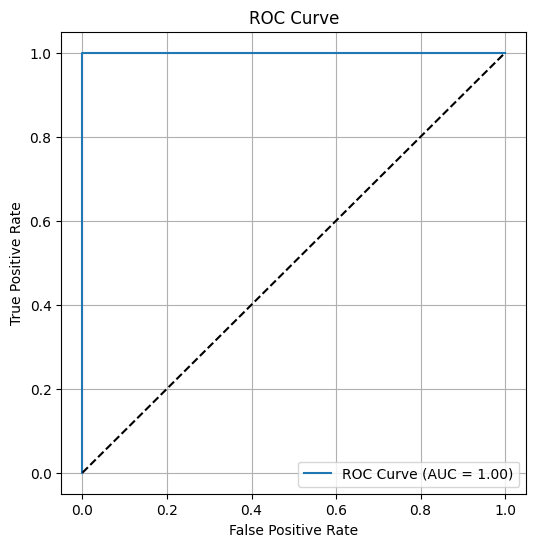

In [ ]:
# 시각화
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Precison-Recall Curve

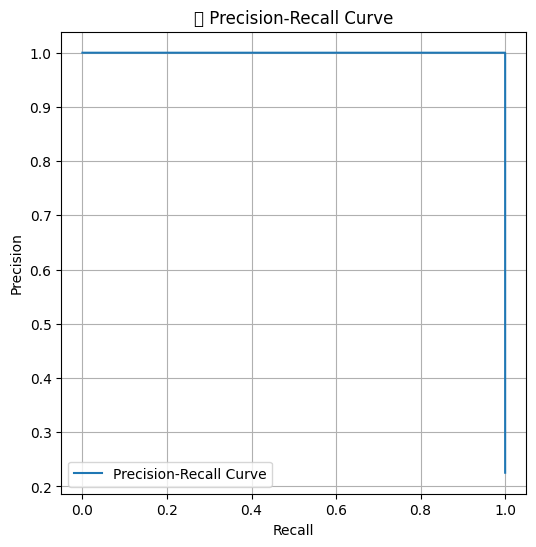

In [ ]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('📊 Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()